In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv("../data/processed/merged_data.csv")

In [3]:
print("Shape do DataFrame:", df.shape)
df.head()

Shape do DataFrame: (12202, 19)


,vaga_id,candidato_id,situacao,comentario,nome,titulo_vaga,modalidade_vaga,cliente,sap,nivel_profissional,idioma,competencias_tecnicas,nivel_academico,ingles,espanhol,area_atuacao,conhecimentos,cv,target
0,4531,25364,Contratado pela Decision,Data de Inicio: 12/04/2021,Sra. Yasmin Fernandes,2021-2607395-PeopleSoft Application Engine-Dom...,NaN,Gonzalez and Sons,Não,Sênior,Nenhum,O recurso Peoplesoft tem como responsabilidade...,Ensino Superior Completo,Avançado,Intermediário,TI - Projetos,"- PeopleSoft (PeopleTools 8.49, 8.53, 8.55, 8....",\n\nárea de atuação: lider de consultoria / ge...,1
1,4533,26338,Contratado pela Decision,NaN,Arthur Almeida,2021-2605708-Microfocus Application Life Cycle...,NaN,Barnes-Woods,Não,Sênior,Técnico,Arquiteto\n\nFoco na área e automação.\n\nRequ...,NaN,NaN,NaN,NaN,NaN,"solteiro, brasileiro, 21/06/1987\nhabilitação ...",1
2,4533,24645,Desistiu,Profissional desistiu da vaga. Motivo : Na ver...,Dante Sampaio,2021-2605708-Microfocus Application Life Cycle...,NaN,Barnes-Woods,Não,Sênior,Técnico,Arquiteto\n\nFoco na área e automação.\n\nRequ...,NaN,NaN,NaN,NaN,NaN,analista de teste/qa\n\nprofissional hands on ...,0
3,4534,26205,Desistiu,"profissional não atende ou responde ligações, ...",Isabella da Cruz,2021-2605711-Microfocus QTP - UFT Automation T...,NaN,Barnes-Woods,Não,Sênior,Técnico,Automação de teste (conhecimento do código)\n\...,NaN,NaN,NaN,NaN,NaN,"idade: 37 anos\n172 apto.2703, vila maria josé...",0
4,4534,26003,Não Aprovado pelo Cliente,"""Conversando com a candidata, foi exposto que ...",Maria Helena Peixoto,2021-2605711-Microfocus QTP - UFT Automation T...,NaN,Barnes-Woods,Não,Sênior,Técnico,Automação de teste (conhecimento do código)\n\...,NaN,NaN,NaN,NaN,NaN,solteira – 40 anos – brasileira\nitaquaquecetu...,0


In [4]:
# Cópia de trabalho
df_model = df.copy()

# Colunas utilizadas na modelagem
cols_utilizadas = [
    "nivel_academico",
    "ingles",
    "espanhol",
    "area_atuacao",
    "nivel_profissional",
    "sap",
    "cliente",
    "target",
]

# Filtrar apenas essas colunas
df_model = df_model[cols_utilizadas]

In [5]:
# Preencher nulos e padronizar valores categóricos
for col in df_model.columns:
    if df_model[col].dtype == "object":
        df_model[col] = (
            df_model[col].fillna("Desconhecido").astype(str).str.strip().str.title()
        )

In [6]:
def agrupar_raros(coluna, top_n=20):
    top_valores = df_model[coluna].value_counts().nlargest(top_n).index
    return df_model[coluna].apply(lambda x: x if x in top_valores else "Outros")


# Aplicar em cliente e área de atuação
df_model["cliente"] = agrupar_raros("cliente", top_n=20)
df_model["area_atuacao"] = agrupar_raros("area_atuacao", top_n=20)

In [7]:
df_model.info()
df_model.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12202 entries, 0 to 12201
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   nivel_academico     12202 non-null  object
 1   ingles              12202 non-null  object
 2   espanhol            12202 non-null  object
 3   area_atuacao        12202 non-null  object
 4   nivel_profissional  12202 non-null  object
 5   sap                 12202 non-null  object
 6   cliente             12202 non-null  object
 7   target              12202 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 762.8+ KB


,nivel_academico,ingles,espanhol,area_atuacao,nivel_profissional,sap,cliente,target
0,Ensino Superior Completo,Avançado,Intermediário,Ti - Projetos,Sênior,Não,Gonzalez And Sons,1
1,Desconhecido,Desconhecido,Desconhecido,Desconhecido,Sênior,Não,Barnes-Woods,1
2,Desconhecido,Desconhecido,Desconhecido,Desconhecido,Sênior,Não,Barnes-Woods,0
3,Desconhecido,Desconhecido,Desconhecido,Desconhecido,Sênior,Não,Barnes-Woods,0
4,Desconhecido,Desconhecido,Desconhecido,Desconhecido,Sênior,Não,Barnes-Woods,0


In [8]:
df_model.to_csv("../data/processed/df_model.csv", index=False)

In [9]:

# Separar variáveis explicativas e alvo
X = df_model.drop(columns="target")
y = df_model["target"]

# Divisão treino/teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [10]:
X_test.to_csv("../data/processed/X_test.csv", index=False)

In [11]:

# Todas as colunas são categóricas
categorical_features = X.columns.tolist()

# Transformador para OneHotEncoding
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)]
)

# Pipeline completo
pipeline_balanced = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        (
            "classifier",
            RandomForestClassifier(
                n_estimators=100, random_state=42, class_weight="balanced"
            ),
        ),
    ]
)

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1844
           1       0.50      0.54      0.52       597

    accuracy                           0.76      2441
   macro avg       0.68      0.68      0.68      2441
weighted avg       0.76      0.76      0.76      2441



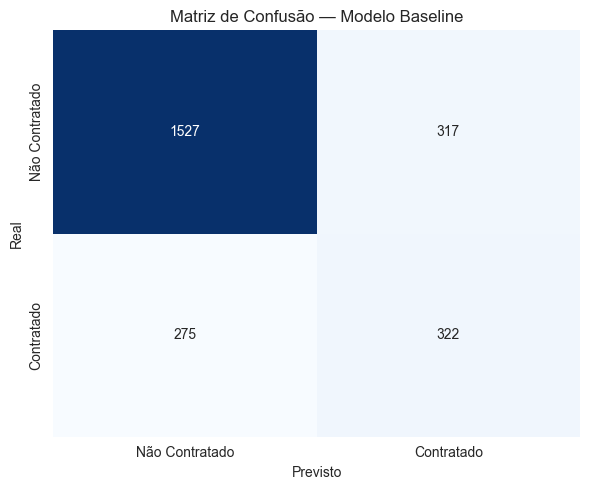

In [12]:

# Treinamento
pipeline_balanced.fit(X_train, y_train)

# Predição
y_pred = pipeline_balanced.predict(X_test)

# Avaliação
print(classification_report(y_test, y_pred))

# Calcular matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plot com Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Não Contratado", "Contratado"],
    yticklabels=["Não Contratado", "Contratado"],
)

plt.title("Matriz de Confusão — Modelo Baseline")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [13]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Calculando a razão entre classes para o scale_pos_weight
neg, pos = y_train.value_counts()
scale = neg / pos

# Pipeline com XGBoost
pipeline_xgb = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        (
            "classifier",
            XGBClassifier(
                random_state=42,
                use_label_encoder=False,
                eval_metric="logloss",
                scale_pos_weight=scale,  # compensação de classe
            ),
        ),
    ]
)

/Users/joaopedroc.dias/Desktop/ml_recruitment_model/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:59:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1844
           1       0.50      0.54      0.52       597

    accuracy                           0.75      2441
   macro avg       0.67      0.68      0.68      2441
weighted avg       0.76      0.75      0.76      2441



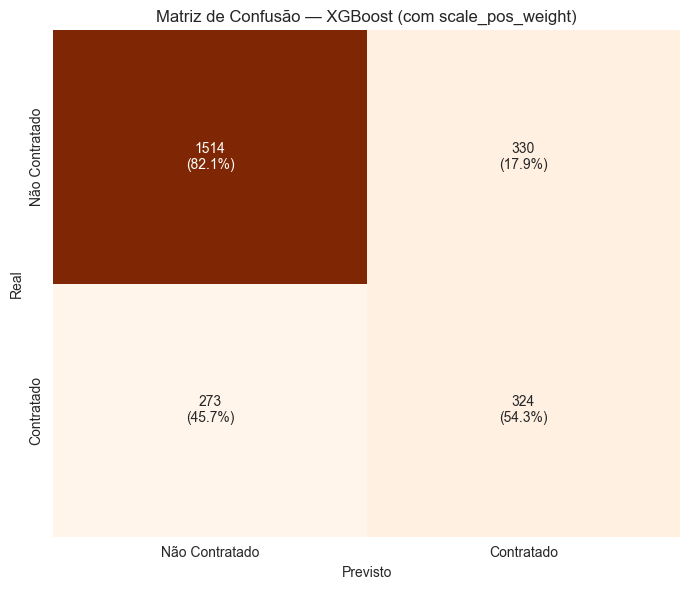

In [14]:
# Treinamento
pipeline_xgb.fit(X_train, y_train)

# Predição
y_pred_xgb = pipeline_xgb.predict(X_test)

# Avaliação
print(classification_report(y_test, y_pred_xgb))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_xgb)
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100
labels = np.array(
    [
        [f"{v}\n({p:.1f}%)" for v, p in zip(row_val, row_pct)]
        for row_val, row_pct in zip(cm, cm_percent)
    ]
)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=labels,
    fmt="",
    cmap="Oranges",
    cbar=False,
    xticklabels=["Não Contratado", "Contratado"],
    yticklabels=["Não Contratado", "Contratado"],
)

plt.title("Matriz de Confusão — XGBoost (com scale_pos_weight)")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

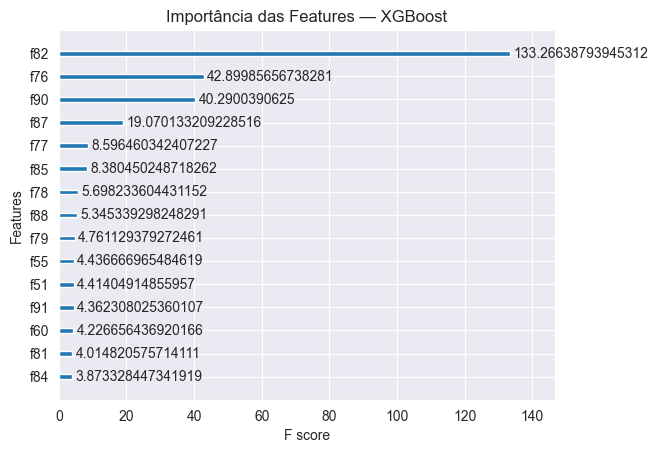

In [15]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Acessar o classificador do pipeline
xgb_model = pipeline_xgb.named_steps["classifier"]

# Plotar importância
xgb.plot_importance(xgb_model, max_num_features=15, importance_type="gain")
plt.title("Importância das Features — XGBoost")
plt.show()

In [ ]:
import pandas as pd

# Obter nomes das features após transformação
encoded_feature_names = pipeline_xgb.named_steps[
    "preprocessing"
].get_feature_names_out()

# Combinar com a importância do modelo
importance = xgb_model.feature_importances_

# Criar DataFrame com nomes legíveis
feat_imp_df = pd.DataFrame(
    {"feature": encoded_feature_names, "importance": importance}
).sort_values(by="importance", ascending=False)

# Visualizar top 15
feat_imp_df.head(15)

In [ ]:
import joblib

# Salvar o pipeline completo
joblib.dump(pipeline_xgb, "../models/modelo_priorizacao_xgb.pkl")

In [18]:
def priorizar_candidatos(df_input, modelo, top_n=10):
    """
    Recebe um DataFrame de candidatos e retorna os top_n com maior probabilidade de contratação.
    """
    df_copy = df_input.copy()
    df_copy = df_copy.drop(columns=["target"], errors="ignore")

    # Previsão
    probs = modelo.predict_proba(df_copy)[:, 1]
    df_copy["prob_contratacao"] = probs

    # Ordenação
    df_ranked = df_copy.sort_values(by="prob_contratacao", ascending=False)

    return df_ranked.head(top_n)

In [19]:
# Exemplo de uso com X_test
top_priorizados = priorizar_candidatos(X_test.copy(), pipeline_xgb, top_n=5)
top_priorizados.head()

,nivel_academico,ingles,espanhol,area_atuacao,nivel_profissional,sap,cliente,prob_contratacao
10493,Ensino Superior Cursando,Intermediário,Básico,Ti - Sistemas E Ferramentas,Sênior,Não,Gonzalez And Sons,0.997305
10048,Ensino Médio Completo,Avançado,Básico,Ti - Sap,Sênior,Não,Jenkins-Walker,0.987796
7230,Ensino Superior Completo,Básico,Básico,Ti - Sap,Pleno,Não,Miller-Curry,0.980813
5799,Ensino Superior Completo,Básico,Intermediário,Ti - Sap,Pleno,Não,Miller-Curry,0.979685
10602,Ensino Superior Completo,Básico,Nenhum,Ti - Projetos,Sênior,Não,Gonzalez And Sons,0.969872
